# Analysis of our Network

In [1]:
import networkx as nx
from shapely import wkt
import json
import matplotlib.pyplot as plt
import time
import networkx.algorithms.community as nxcom
import os
import numpy as np
import networkx as nx
import rasterio
from rasterio.mask import mask
import numpy as np
from datetime import date, timedelta
from shapely.plotting import patch_from_polygon

In [2]:
nx_ntl = nx.read_gml('county_graph_with_ntl.gml')
def normalize_weights(graph, date_str):
    # Calculate the average ntl_sum for each edge
    for u, v in graph.edges():
        ntl_u = json.loads(graph.nodes[u]['ntl'])
        ntl_v = json.loads(graph.nodes[v]['ntl'])
        
        # Calculate the average ntl_sum for the two nodes
        avg_ntl_sum = (ntl_u[date_str][f'{date_str}_avg'] + ntl_v[date_str][f'{date_str}_avg']) / 2
        
        # Assign the average ntl_sum as the weight of the edge
        graph[u][v]['weight'] = avg_ntl_sum
    
    # Normalize the weights between 0 and 1
    weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    min_weight = min(weights)
    max_weight = max(weights)
    
    for u, v in graph.edges():
        graph[u][v]['weight'] = 1 - ((graph[u][v]['weight'] - min_weight) / (max_weight - min_weight))

# Apply the function to the graph with a specific date
normalize_weights(nx_ntl, '2024-09-25')

# Convert the 'geometry' from WKT string back to Shapely geometry and 'ntl' from JSON string back to dictionary
for node, data in nx_ntl.nodes(data=True):
    if 'geometry' in data:
        data['geometry'] = wkt.loads(data['geometry'])
    if 'ntl' in data:
        data['ntl'] = json.loads(data['ntl'])

# Verify the conversion
first_node = list(nx_ntl.nodes(data=True))[0]
print(first_node)

('Georgia_Appling', {'state': 'Georgia', 'county': 'Appling', 'geometry': <MULTIPOLYGON (((-82.227 31.531, -82.228 31.532, -82.228 31.533, -82.229 31....>, 'ntl': {'2023-09-01': {'2023-09-01_sum': 55178.0, '2023-09-01_avg': 3.8318055555555555}, '2023-09-02': {'2023-09-02_sum': 43314.0, '2023-09-02_avg': 3.0079166666666666}, '2023-09-03': {'2023-09-03_sum': 50646.0, '2023-09-03_avg': 3.5170833333333333}, '2023-09-04': {'2023-09-04_sum': 81750.0, '2023-09-04_avg': 5.677083333333333}, '2023-09-05': {'2023-09-05_sum': 54391.0, '2023-09-05_avg': 3.777152777777778}, '2023-09-06': {'2023-09-06_sum': 55446.0, '2023-09-06_avg': 3.850416666666667}, '2023-09-07': {'2023-09-07_sum': 59246.0, '2023-09-07_avg': 4.114305555555555}, '2023-09-08': {'2023-09-08_sum': 59283.0, '2023-09-08_avg': 4.116875}, '2023-09-09': {'2023-09-09_sum': 80733.0, '2023-09-09_avg': 5.606458333333333}, '2023-09-10': {'2023-09-10_sum': 77241.0, '2023-09-10_avg': 5.363958333333334}, '2023-09-11': {'2023-09-11_sum': 71635.0, 

In [3]:
print(nx_ntl)

Graph with 205 nodes and 567 edges


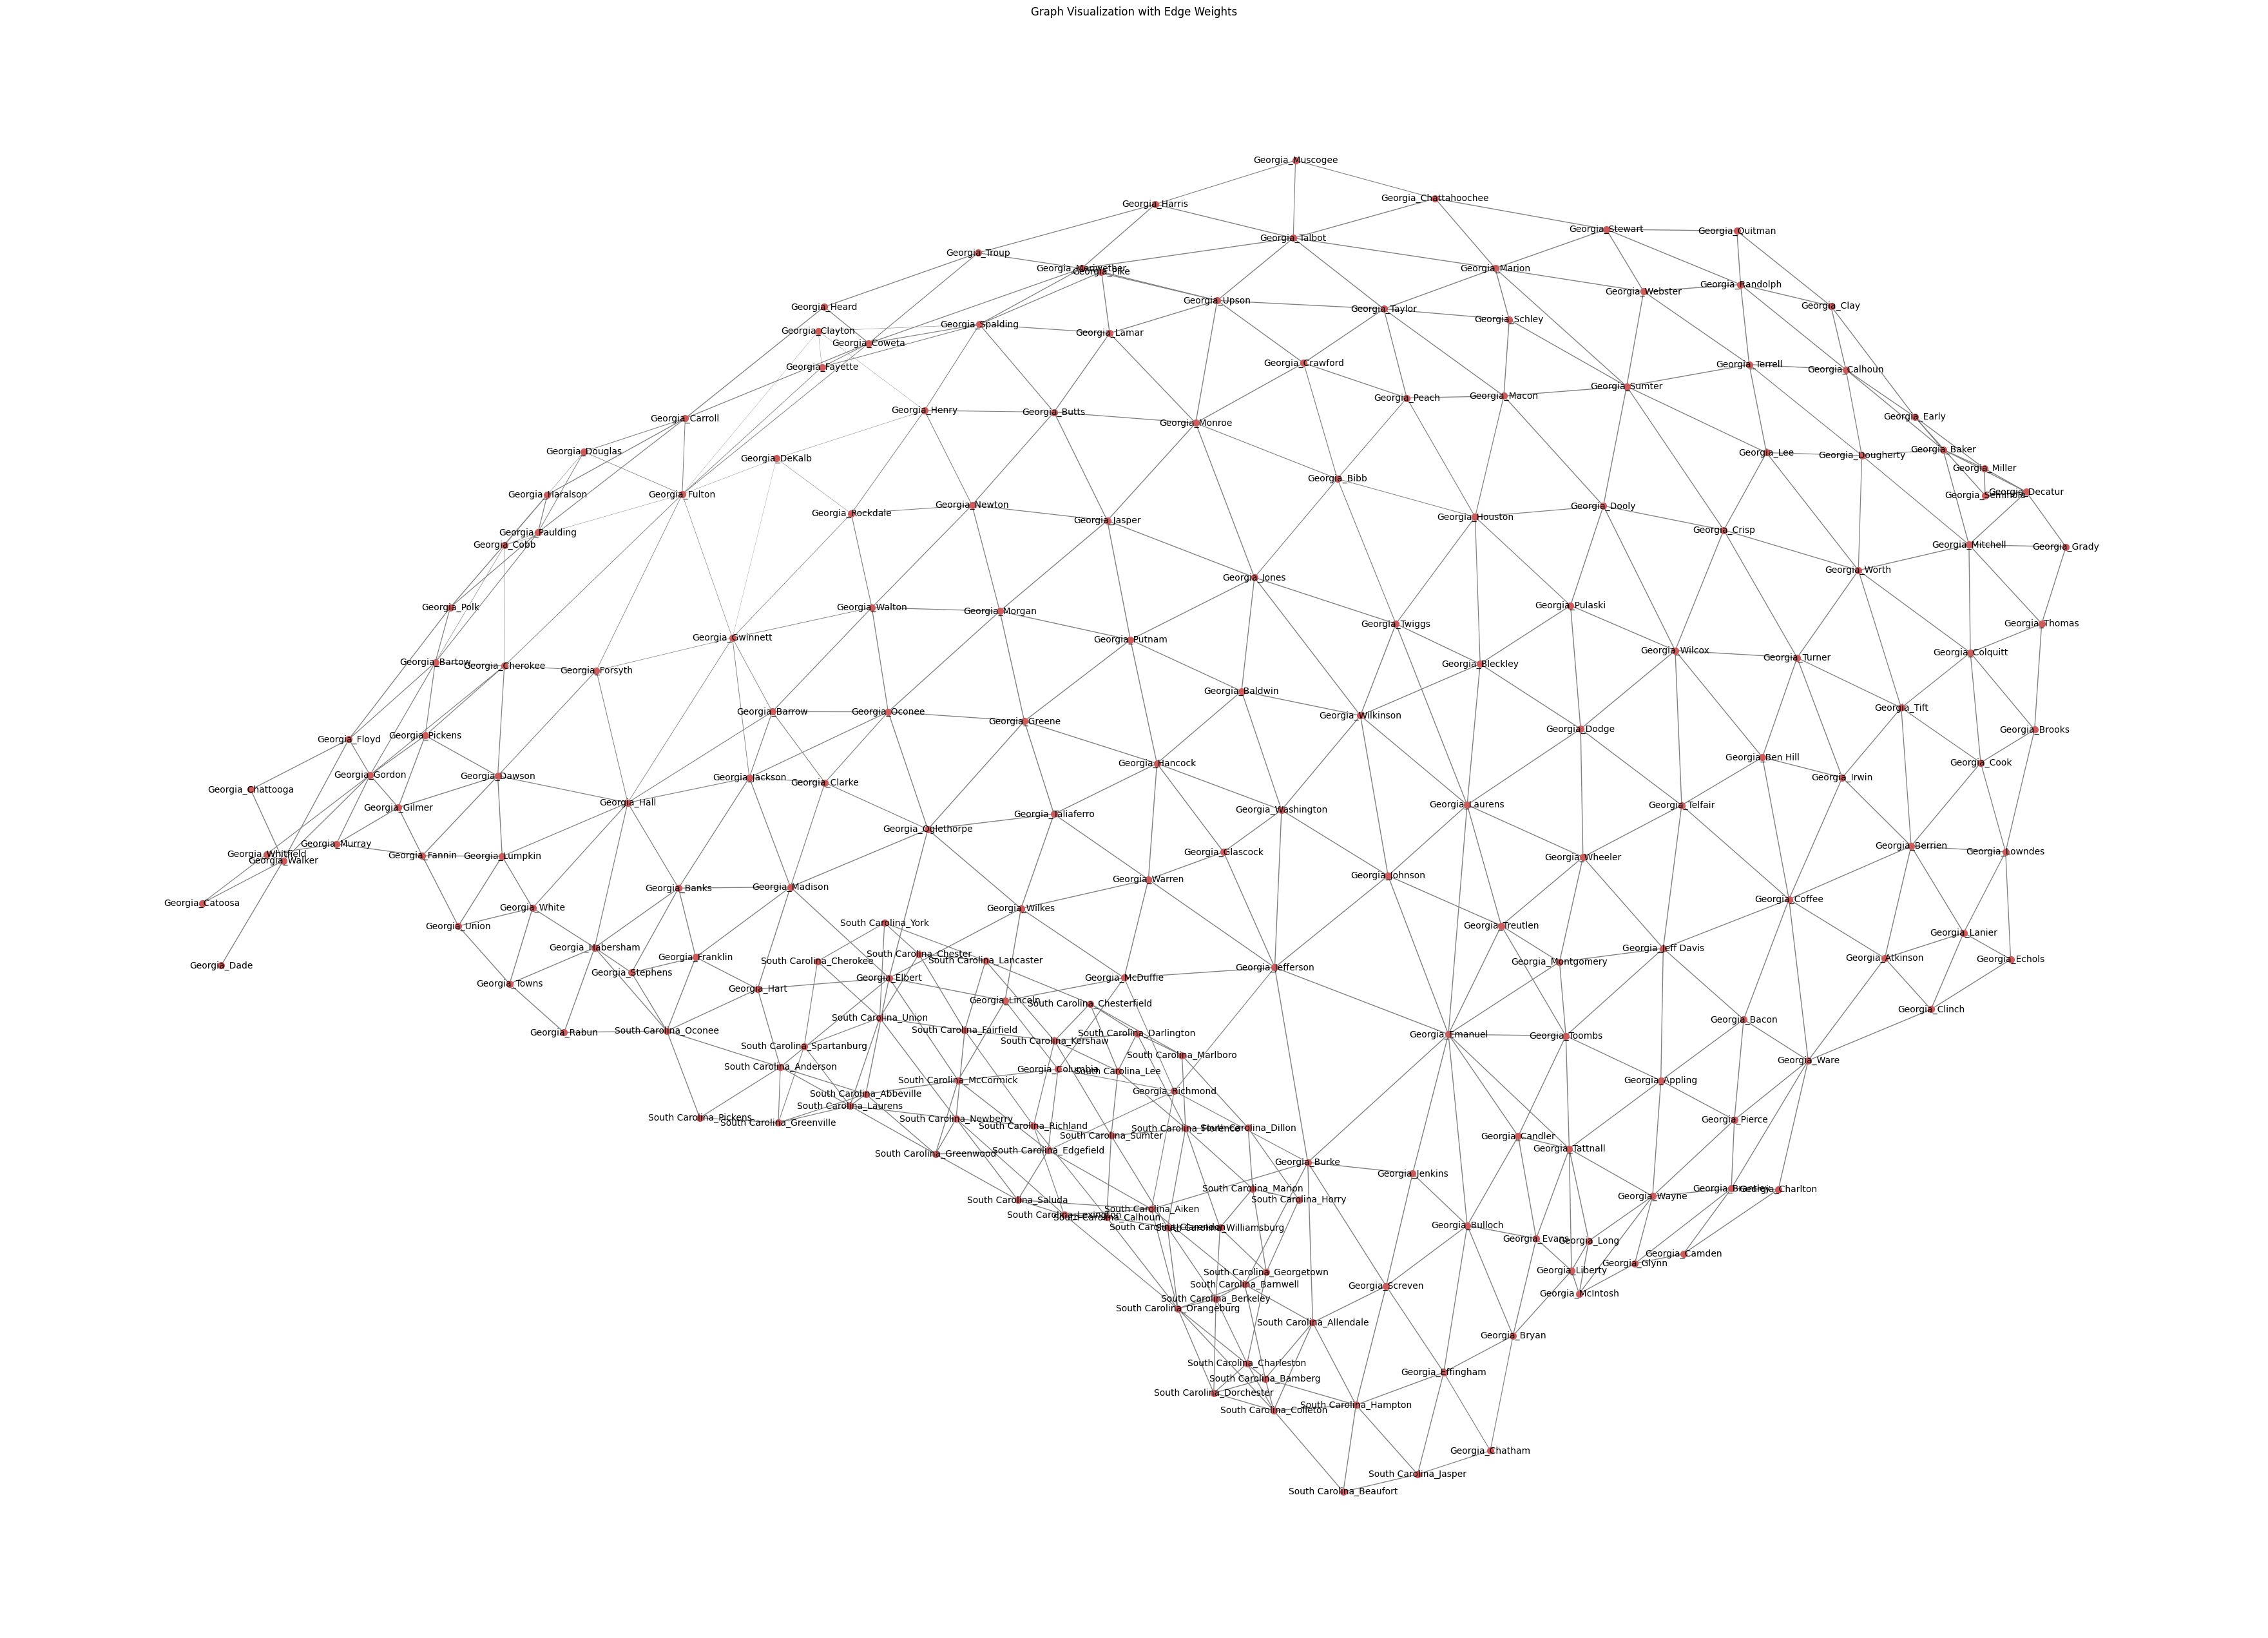

In [4]:
# Draw the graph
os.makedirs("visualizations", exist_ok=True)

# Define the graph layout
pos = nx.spring_layout(nx_ntl, seed=39)  # Choose a layout, e.g., spring layout

# Plot the graph with weights
plt.figure(figsize=(35, 25))

# Extract the weights to use as edge thickness
weights = [nx_ntl[u][v]['weight'] for u, v in nx_ntl.edges()]

# Draw the graph with edge weights affecting edge thickness
nx.draw(
    nx_ntl, pos, 
    with_labels=True, 
    node_size=50, 
    font_size=10, 
    edge_color="gray", 
    node_color="indianred",
    width=weights  # Adjust edge width based on weight
)

# Title and save the figure
plt.title("Graph Visualization with Edge Weights")
plt.savefig('visualizations/graph_visualization_with_weights.png', dpi=300, bbox_inches='tight')
plt.show()


# Nearest Neighbor Analysis
**Objective:** Analyze how the degree of a node's neighbors depends on the node's degree. Compute the average degree of neighbors knn(k) for nodes with degree k.

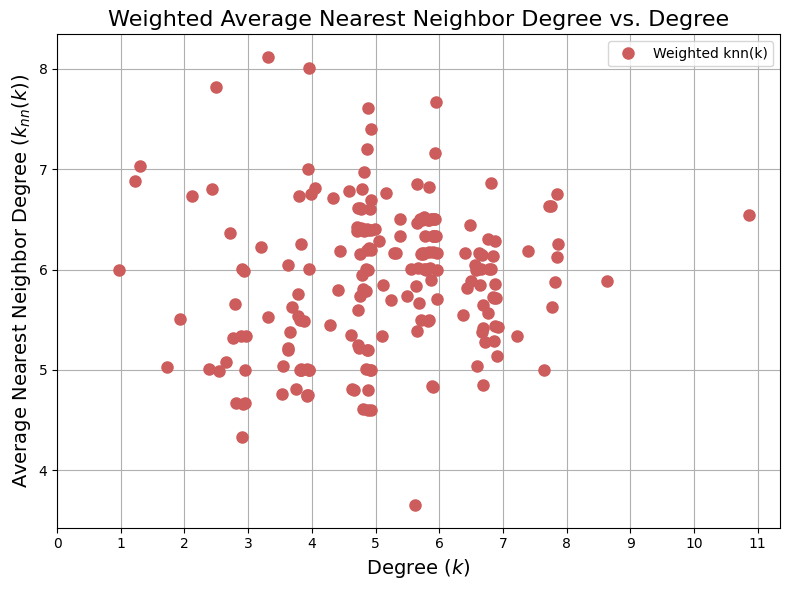

In [5]:
# Calculate the weighted degree of each node (sum of edge weights)
node_degrees = dict(nx.degree(nx_ntl, weight='weight'))

# Compute the weighted average neighbor degree of each node
avg_neighbor_degree = nx.average_neighbor_degree(nx_ntl, weight='weight')

# Group by degree to compute knn(k) as a function of degree
degree_knn = {}
for node, degree in node_degrees.items():
    # Get the average neighbor degree for each node
    avg_deg = avg_neighbor_degree[node]
    
    # Add the average neighbor degree to the correct degree group
    if degree not in degree_knn:
        degree_knn[degree] = []
    degree_knn[degree].append(avg_deg)

# Calculate the average knn(k) for each degree
degrees = sorted(degree_knn.keys())
knn_values = [np.mean(degree_knn[degree]) for degree in degrees]

# Plotting the result
plt.figure(figsize=(8, 6))
plt.plot(degrees, knn_values, 'o', color='indianred', label="Weighted knn(k)", markersize=8)
plt.xlabel("Degree ($k$)", fontsize=14)
plt.ylabel("Average Nearest Neighbor Degree ($k_{nn}(k)$)", fontsize=14)
plt.title("Weighted Average Nearest Neighbor Degree vs. Degree", fontsize=16)
plt.xticks(range(12))  # Show all degree values on x-axis
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


This plot examines the relationship between node degree (k) and the weighted average nearest neighbor degree (knn(k)) in a network of Georgia's counties, where edges represent shared borders and are weighted by the average NTL values of connected counties. The absence of a strong trend suggests a weak assortativity, meaning high-degree counties do not exclusively connect to other high-degree counties. The variability in knn(k) for low-degree nodes indicates that less-connected counties interact with both sparsely and densely connected neighbors, likely reflecting a mix of urban hubs and rural peripheries. For higher-degree nodes,knn(k) stabilizes, implying that well-connected counties are linked to neighbors of relatively similar degree and development. This pattern reflects a balance between geographic constraints and socioeconomic factors, with NTL weights emphasizing developmental similarities in the network's connectivity. Overall, the network reveals both structural heterogeneity and regional clustering shaped by geography and development.

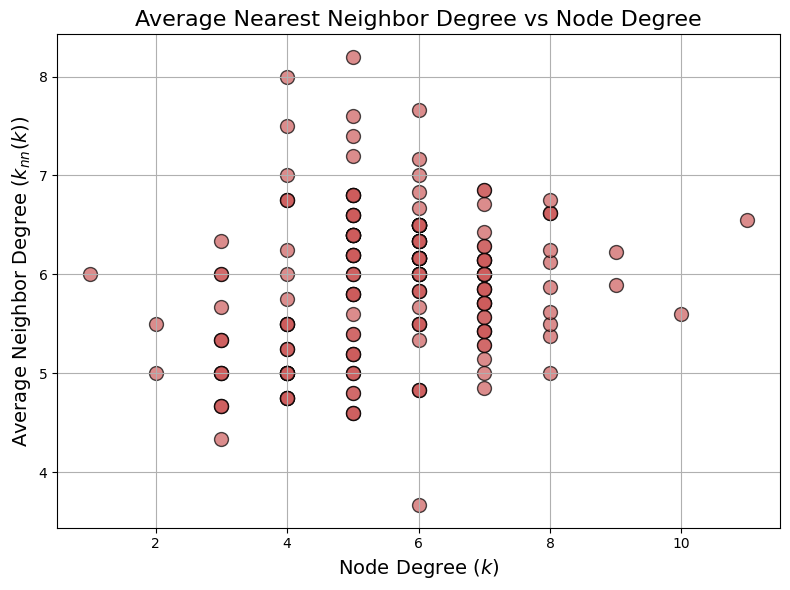

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Calculate the degree of each node
node_degrees = dict(nx_ntl.degree())

# Compute the average neighbor degree of each node
avg_neighbor_degree = nx.average_neighbor_degree(nx_ntl)

# Group by degree to compute knn(k) as a function of degree
degree_knn = {}
for node, degree in node_degrees.items():
    if degree not in degree_knn:
        degree_knn[degree] = []
    degree_knn[degree].append(avg_neighbor_degree[node])

# Calculate the average knn(k) for each degree
degrees = sorted(degree_knn.keys())
knn_values = [np.mean(degree_knn[degree]) for degree in degrees]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(node_degrees.values(), list(avg_neighbor_degree.values()), color='indianred', alpha=0.7, edgecolors='k', s=100)
plt.xlabel("Node Degree ($k$)", fontsize=14)
plt.ylabel("Average Neighbor Degree ($k_{nn}(k)$)", fontsize=14)
plt.title("Average Nearest Neighbor Degree vs Node Degree", fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()


This plot shows the relationship between node degree (k) and the average nearest neighbor degree (knn(k)) in the Georgia county network, where edges represent shared borders, but without weighting by NTL. Unlike the previous weighted analysis, this unweighted version reflects purely the structural topology of the network. The clustering of knn(k) values around 5–7 across all degrees suggests a relatively homogeneous local connectivity, with high-degree nodes connecting to neighbors with a similar degree range. The lack of a strong upward or downward trend in knn(k) indicates weak or no assortative mixing, implying that counties with high connectivity are just as likely to connect to counties with low connectivity. This uniformity might be driven by geographic constraints, where adjacency between counties naturally limits degree variation. Overall, the network appears structurally balanced, with no pronounced hubs dominating its topology.

In [8]:
assortativity_coefficient = nx.degree_assortativity_coefficient(nx_ntl)

print(f"Assortativity Coefficient by Degree: {assortativity_coefficient:.4f}")

assortativity_coefficient_w = nx.degree_assortativity_coefficient(nx_ntl, weight='weight')

print(f"Weighted Assortativity Coefficient by Degree: {assortativity_coefficient_w:.4f}")


Assortativity Coefficient by Degree: 0.0744
Weighted Assortativity Coefficient by Degree: 0.1735


# Interpretation
The Assortativity Coefficient by Degree: 0.0744 suggests that there is at max a slight positive correlation between the degrees of connected nodes in the network. In other words, nodes with similar degrees are somewhat more likely to be connected, but the correlation is very very weak.

The Weighted Assortativity Coefficient by Degree: 0.1735 indicates a moderately positive correlation when considering the weights of the edges. This means that nodes with similar weighted degrees (i.e., the sum of the weights of their connections) are more likely to be connected, and the correlation is stronger than in the unweighted case.

In summary, the network shows a weak tendency for nodes with similar degrees to connect, and this tendency becomes more noticeable when edge weights are considered.

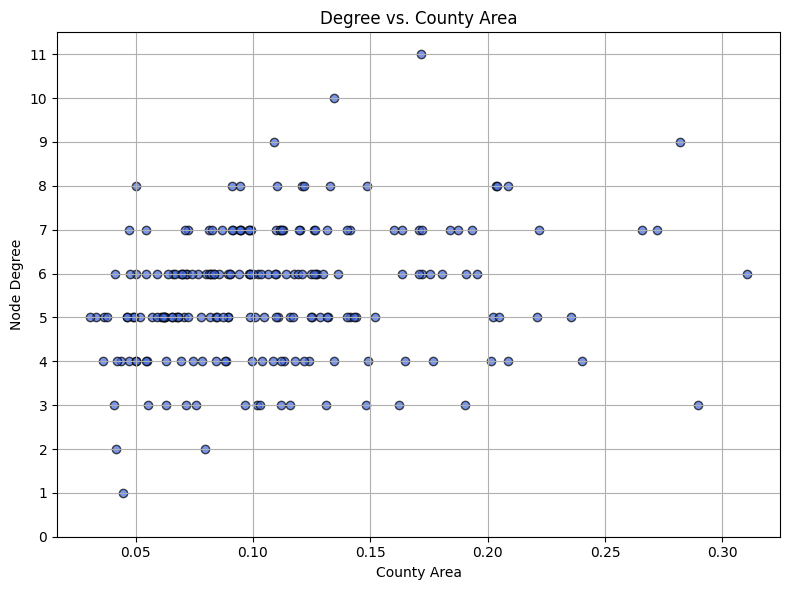

In [9]:
# Extract areas of counties and degrees of nodes
areas = {data["state"]+"_"+data["county"]: data["geometry"].area for node, data in nx_ntl.nodes(data=True)}
degrees = dict(nx_ntl.degree())

# Ensure the nodes in areas and degrees match
common_nodes = set(areas.keys()) & set(degrees.keys())

# Filter data to only include common nodes
areas_filtered = [areas[node] for node in common_nodes]
degrees_filtered = [degrees[node] for node in common_nodes]

# Plot degree vs. area
plt.figure(figsize=(8, 6))
plt.scatter(areas_filtered, degrees_filtered, alpha=0.7, edgecolors='k', c='royalblue')

# Optional: Add a trendline
z = np.polyfit(areas_filtered, degrees_filtered, 1)
p = np.poly1d(z)

# Customize plot
plt.title("Degree vs. County Area")
plt.xlabel("County Area")
plt.ylabel("Node Degree")
plt.yticks(range(12))
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

The relationship between node degree and county area reveals insights into how geography influences the connectivity of counties within the network. Most counties having 4–6 neighbors suggests a consistent level of local connectivity, likely driven by the administrative and geographic organization of Georgia. However, the observation that larger counties tend to have fewer neighbors indicates an inverse relationship between area and degree. This pattern arises because larger counties typically occupy more space, reducing the number of bordering counties they can connect to. Smaller counties, by contrast, are often clustered in more densely subdivided regions, leading to higher degrees. This trend reflects the spatial constraints on the network's topology, where geographic size plays a key role in shaping the connectivity patterns. Such findings emphasize the balance between physical size and adjacency in determining the structural properties of the network. Also, we can see that there are more smaller counties in Georgia.


# Degree Probability Density in Logarithmic Scale
**Objective:** Plot the degree distribution in a log-log scale to observe if the network follows a power-law or has a characteristic scale.

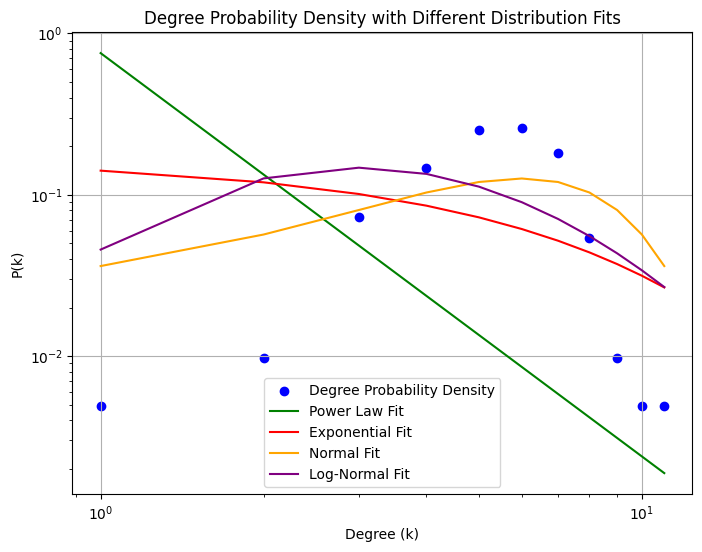

In [10]:
from scipy.stats import powerlaw, norm, lognorm, expon

# Degree calculation and degree probability density
degrees = [d for n, d in nx_ntl.degree()]
degree_counts = np.bincount(degrees)
degree_prob = degree_counts / sum(degree_counts)

# Plot degree distribution
plt.figure(figsize=(8, 6))
x = np.arange(len(degree_prob))[1:]  # Exclude degree 0
y = degree_prob[1:]
plt.scatter(x, y, color='blue', label='Degree Probability Density')

# Fit and plot Power Law
alpha = 2.5  # This is a typical power law exponent (you may estimate it from your data)
powerlaw_pdf = (alpha - 1) * (x) ** (-alpha)
plt.plot(x, powerlaw_pdf / sum(powerlaw_pdf), color='green', label='Power Law Fit')

# Fit and plot Exponential Distribution
lambda_exp = 1 / np.mean(x)  # Fit lambda based on the mean degree
exponential_pdf = expon.pdf(x, scale=1/lambda_exp)
plt.plot(x, exponential_pdf, color='red', label='Exponential Fit')

# Fit and plot Normal Distribution
mean_deg = np.mean(x)
std_deg = np.std(x)
normal_pdf = norm.pdf(x, loc=mean_deg, scale=std_deg)
plt.plot(x, normal_pdf, color='orange', label='Normal Fit')

# Fit and plot Log-Normal Distribution
shape, loc, scale = lognorm.fit(x, floc=0)  # Fit log-normal to the data
lognormal_pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, lognormal_pdf, color='purple', label='Log-Normal Fit')

# Plot settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Degree Probability Density with Different Distribution Fits')
plt.grid(True)
plt.legend()
plt.show()

# TODO: comment

# Community analysis

Greedy Modularity - Unweighted: 5 communities detected
Greedy Modularity - Weighted: 5 communities detected
Label Propagation - Unweighted: 28 communities detected
Label Propagation - Weighted: 28 communities detected


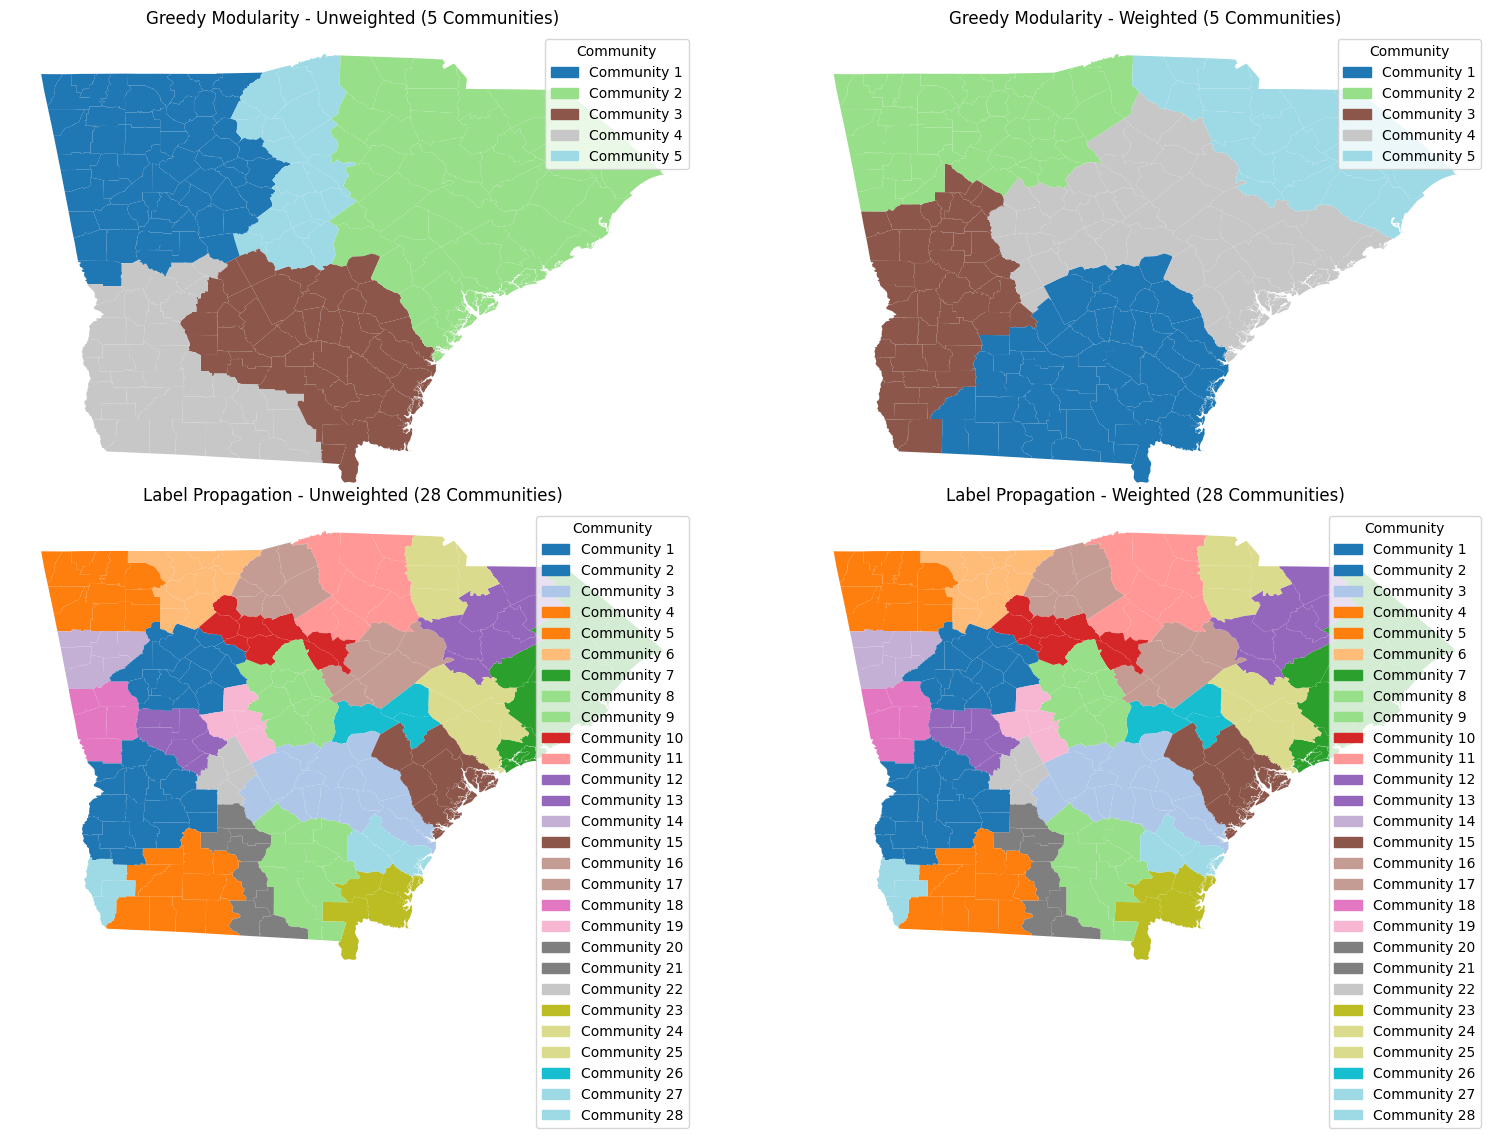

In [15]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import networkx.algorithms.community as nxcom
import geopandas as gpd

# Detect communities
def detect_communities(graph, weighted=False, algorithm='greedy'):
    if algorithm == 'greedy':
        if weighted:
            communities = sorted(nxcom.greedy_modularity_communities(graph, weight='weight'), key=len, reverse=True)
        else:
            communities = sorted(nxcom.greedy_modularity_communities(graph), key=len, reverse=True)
    elif algorithm == 'label_propagation':
        if weighted:
            communities = sorted(nxcom.label_propagation_communities(graph), key=len, reverse=True)
        else:
            communities = sorted(nxcom.label_propagation_communities(graph), key=len, reverse=True)
    return communities

# Assign communities to nodes
def assign_community_to_nodes(graph, communities):
    for c, community in enumerate(communities):
        for node in community:
            graph.nodes[node]['community'] = c + 1  # Communities start from 1

# Create GeoDataFrame
def create_geodataframe(graph):
    return gpd.GeoDataFrame(
        [(node, data['geometry'], data['community']) for node, data in graph.nodes(data=True)],
        columns=['county', 'geometry', 'community']
    )

# Custom plot function with a consistent color legend
def plot_communities_with_legend(gdf, ax, title):
    # Generate distinct colors for communities
    num_communities = gdf['community'].nunique()
    cmap = plt.get_cmap('tab20', num_communities)  # Ensure enough colors
    norm = mcolors.BoundaryNorm(range(1, num_communities + 2), cmap.N)
    
    # Plot the communities
    gdf.plot(ax=ax, column='community', cmap=cmap, norm=norm, legend=False)
    
    # Custom legend
    patches = [mpatches.Patch(color=cmap(norm(i)), label=f'Community {i}') for i in range(1, num_communities + 1)]
    ax.legend(handles=patches, loc='upper right', title="Community")
    
    # Title and axis off
    ax.set_title(title)
    ax.axis('off')

# Community detection configurations
configs = [
    ('Greedy Modularity - Unweighted', False, 'greedy'),
    ('Greedy Modularity - Weighted', True, 'greedy'),
    ('Label Propagation - Unweighted', False, 'label_propagation'),
    ('Label Propagation - Weighted', True, 'label_propagation')
]

# Create the 2x2 plot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (title, weighted, algorithm) in enumerate(configs):
    communities = detect_communities(nx_ntl, weighted, algorithm)
    print(f"{title}: {len(communities)} communities detected")
    assign_community_to_nodes(nx_ntl, communities)
    gdf = create_geodataframe(nx_ntl)
    
    ax = axes[idx // 2, idx % 2]
    plot_communities_with_legend(gdf, ax, f"{title} ({len(communities)} Communities)")

plt.tight_layout()
plt.show()


With Greedy Modularity, both for the weighted and unweighted case, 5 communities could be detected. However, what is interesting, the division of the counties into the communities are not the same for the two cases. For Label prpagration, both times 28 communities were detected and as far as I can see, the divisions are the same. 

The differences in community detection outcomes highlight the influence of edge weights (NTL) on network structure. Greedy Modularity detects 5 communities in both cases but yields different divisions, indicating that weights significantly affect modularity optimization. In contrast, Label Propagation consistently identifies 28 communities with identical divisions, suggesting it is less sensitive to edge weights and more influenced by the network's topology.

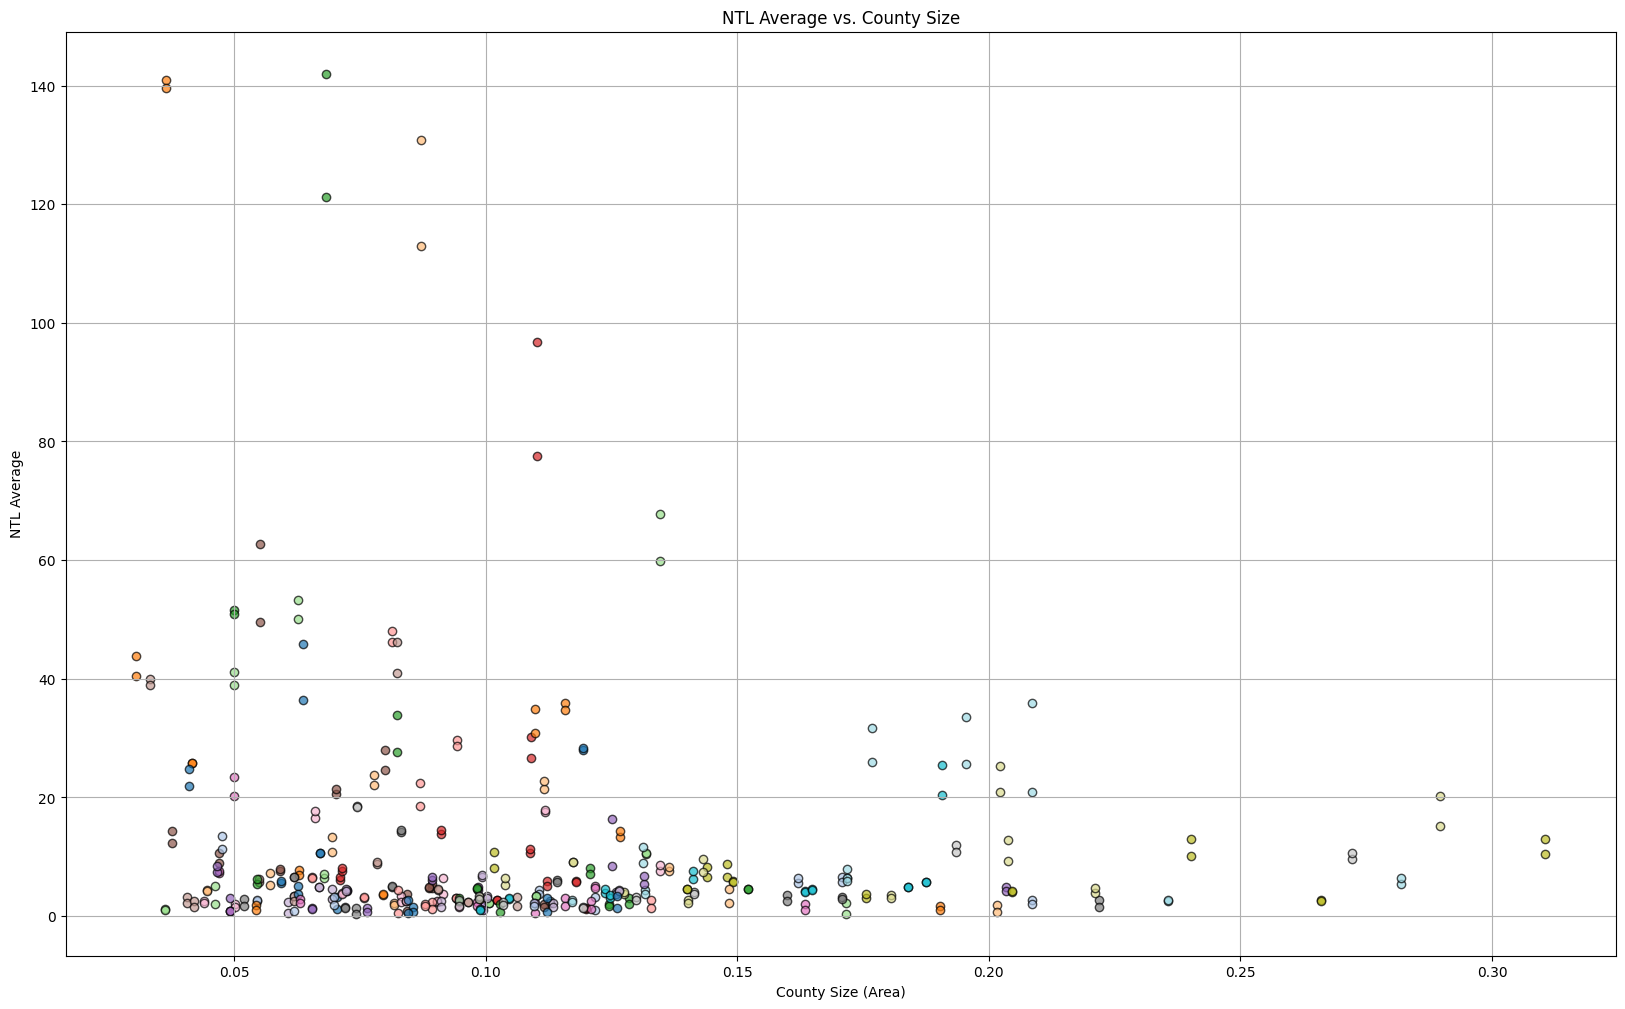

In [16]:
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
import matplotlib.cm as cm

# Extract area and NTL average data
areas = {}
ntl_avgs = {}

# Dates to use for NTL average
target_date_1 = '2024-09-25'
target_date_2 = '2024-09-30'

# Use a colormap to color the points differently (updated)
cmap = plt.colormaps['tab20']  # Use the new method for colormap

# Dictionary to map each county to a unique color
county_colors = {}

for i, (node, data) in enumerate(nx_ntl.nodes(data=True)):
    # Compute county area
    if "geometry" in data:
        try:
            # Ensure the geometry is a string before parsing (in case it is not)
            geometry = wkt.loads(str(data["geometry"]))  # Parse WKT geometry
            if geometry.is_valid:  # Ensure geometry is valid
                areas[node] = geometry.area  # Get the area of the geometry
            else:
                print(f"Invalid geometry for node {node}")
        except Exception as e:
            print(f"Error processing geometry for node {node}: {e}")
            continue
    
    # Extract NTL average for the target dates
    if "ntl" in data:
        try:
            ntl_data = data["ntl"]
            
            # Extract NTL averages for the specified dates
            ntl_avgs[node] = {
                target_date_1: ntl_data.get(target_date_1, {}).get(f"{target_date_1}_avg", 0),
                target_date_2: ntl_data.get(target_date_2, {}).get(f"{target_date_2}_avg", 0)
            }

            # Assign a unique color for each county based on its index
            county_colors[node] = cmap(i / len(nx_ntl.nodes()))  # Normalize the index for the colormap
        except Exception as e:
            print(f"Error processing NTL data for node {node}: {e}")

# Ensure matched nodes for plotting
common_nodes = set(areas.keys()) & set(ntl_avgs.keys())
areas_filtered = [areas[node] for node in common_nodes]
ntl_avgs_filtered_1 = [ntl_avgs[node][target_date_1] for node in common_nodes]
ntl_avgs_filtered_2 = [ntl_avgs[node][target_date_2] for node in common_nodes]

# Check if there is data to plot
if areas_filtered and ntl_avgs_filtered_1 and ntl_avgs_filtered_2:
    # Create the figure
    plt.figure(figsize=(20, 12))

    # Plot NTL average vs. county size for both dates, using consistent colors for each county
    for i, node in enumerate(common_nodes):
        color = county_colors[node]  # Get the color assigned to this county
        
        # Plot for the first date
        plt.scatter(areas[node], ntl_avgs[node][target_date_1], alpha=0.7, edgecolors='k', c=[color])

        # Plot for the second date
        plt.scatter(areas[node], ntl_avgs[node][target_date_2], alpha=0.7, edgecolors='k', c=[color])

    # Add a trendline for the first date (optional)
    z1 = np.polyfit(areas_filtered, ntl_avgs_filtered_1, 1)
    p1 = np.poly1d(z1)

    # Add a trendline for the second date (optional)
    z2 = np.polyfit(areas_filtered, ntl_avgs_filtered_2, 1)
    p2 = np.poly1d(z2)

    # Customize plot
    plt.title("NTL Average vs. County Size")
    plt.xlabel("County Size (Area)")
    plt.ylabel("NTL Average")
    plt.grid(True)

    """
    # Custom legend for county names only (no dates)
    handles = []
    labels = []
    for node in common_nodes:
        if node not in labels:
            # Add the handle and label only if the county hasn't been added yet
            handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=county_colors[node], markersize=10)
            handles.append(handle)
            labels.append(node)

    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    """

    plt.show()

else:
    print("No data to plot. Ensure that there are matching areas and NTL data.")


The plot supports the assumption that larger counties tend to have smaller average NTL values compared to smaller counties, reflecting lower population density or economic activity in these areas (higher rurality). This pattern aligns with the expected relationship between county size and development intensity. However, the impact of the hurricane on average NTL values appears negligible in the data, as there is no clear visible difference between pre- and post-hurricane values. This suggests that either the hurricane's effects on NTL were minimal or that any changes were too subtle to be captured by the current analysis.

In [17]:
from scipy.stats import ttest_rel

# Collect NTL averages for the two dates for common nodes
ntl_avgs_date1 = np.array([ntl_avgs[node][target_date_1] for node in common_nodes])
ntl_avgs_date2 = np.array([ntl_avgs[node][target_date_2] for node in common_nodes])

# Perform a paired t-test
t_stat, p_value = ttest_rel(ntl_avgs_date1, ntl_avgs_date2)

# Print the results
print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The differences in NTL averages before and after the hurricane are statistically significant.")
else:
    print("The differences in NTL averages before and after the hurricane are not statistically significant.")


Paired t-test results: t-statistic = -1.2172594148251785, p-value = 0.22491177638690074
The differences in NTL averages before and after the hurricane are not statistically significant.


Based on the paired t-test results, with a t-statistic of -1.22 and a p-value of 0.225, we can conclude that the differences in NTL averages before and after the hurricane are not statistically significant. The p-value is well above the typical threshold of 0.05, indicating that there is insufficient evidence to suggest that the hurricane had a meaningful impact on the NTL averages of the counties. Therefore, the analysis supports the observation that the NTL differences are negligible.

Correlation between NTL differences of neighboring counties in Georgia: 0.48082629330671645


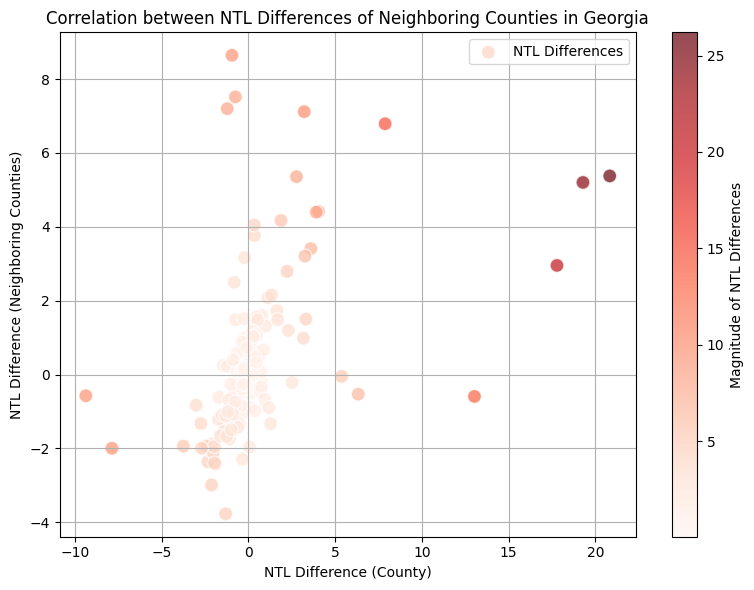

In [58]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import ast
from shapely import wkt

# Load the GML file
file_path = 'county_graph_with_ntl.gml'
nx_ntl = nx.read_gml(file_path)

# Extract NTL Data for Specific Dates (2024-09-25 and 2024-09-30)
target_dates = ['2024-09-25', '2024-09-30']
differences = {}

# Extract county geometries and NTL average values for the two dates
for node, data in nx_ntl.nodes(data=True):
    geometry_wkt = data.get('geometry', None)
    ntl_data = data.get('ntl', None)  # Get NTL data (assumed to be a dictionary or string)
    
    if geometry_wkt and ntl_data:
        try:
            # Parse the geometry
            geometry = wkt.loads(geometry_wkt)
            
            # Convert NTL data to dictionary safely and calculate the difference
            ntl_dict = ast.literal_eval(ntl_data)  # Safely evaluate string dictionary
            before = ntl_dict.get(target_dates[0], {}).get(f"{target_dates[0]}_avg", 0)
            after = ntl_dict.get(target_dates[1], {}).get(f"{target_dates[1]}_avg", 0)
            difference = after - before
            differences[node] = difference
        except Exception as e:
            print(f"Error processing node {node}: {e}")

# Filter for counties in Georgia (assuming Georgia counties are defined or have a naming pattern)
georgia_counties = [node for node, data in nx_ntl.nodes(data=True) if 'Georgia' in node]

# Calculate the NTL differences for neighboring counties
correlations = []
for county in georgia_counties:
    # Get neighbors of the county as a list
    neighbors = list(nx_ntl.neighbors(county))
   
    n_diff = []
    for neighbor in neighbors:
        if neighbor in georgia_counties:  # Ensure the neighbor is also in Georgia
            # Get the difference between the dates of the county
            county_diff = differences.get(county, 0)
            # As well as from the neighbor
            neighbor_diff = differences.get(neighbor, 0)
            n_diff.append(neighbor_diff)
    
    # Calculate average NTL difference of neighbors
    if n_diff:
        avg_neighbor_diff = sum(n_diff) / len(n_diff)
        correlations.append((county_diff, avg_neighbor_diff))

# Convert the correlations to a NumPy array and calculate correlation
correlations = np.array(correlations)

# Calculate the correlation between the NTL differences of neighboring counties
if len(correlations) > 0:
    corr_coef = np.corrcoef(correlations[:, 0], correlations[:, 1])[0, 1]
    print(f"Correlation between NTL differences of neighboring counties in Georgia: {corr_coef}")
else:
    print("No valid correlations found between neighboring counties.")

# Plot the NTL differences of neighboring counties
plt.figure(figsize=(8, 6))

# Scatter plot with color scheme based on the magnitude of differences
c = np.abs(correlations[:, 0]) + np.abs(correlations[:, 1])  # Intensity based on magnitude
plt.scatter(
    correlations[:, 0], 
    correlations[:, 1], 
    c=c, cmap='Reds', alpha=0.7, edgecolors='w', s=100, label='NTL Differences'
)

# Add labels and title
plt.xlabel("NTL Difference (County)")
plt.ylabel("NTL Difference (Neighboring Counties)")
plt.title("Correlation between NTL Differences of Neighboring Counties in Georgia")
plt.colorbar(label="Magnitude of NTL Differences")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


The plot shows that most counties have similar NTL average values compared to their neighboring counties, as the majority of the data points are clustered around zero, indicating little to no change in the difference in NTL averages. This suggests that, generally, the counties' NTL values are fairly consistent with those of their neighbors. However, there are a few notable exceptions, where the difference in NTL averages is much larger, with a few points showing a change of around 20. These outliers may represent counties with distinct characteristics or changes in NTL values that are not typical of the broader trend. Additionally, the correlation between the NTL differences of neighboring counties in Georgia is 0.48, indicating a moderate positive relationship between the NTL changes of a county and its neighbors between September 25, 2024 and September 30, 2024. This suggests that, while there are some disparities, the NTL changes in neighboring counties tend to be somewhat aligned.

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import ast  # Import for safely evaluating strings as Python objects

# Compute Centrality Measures (without NTL weights for closeness and degree)
centrality_measures = {
    "degree": nx.degree_centrality(nx_ntl),  # Unweighted degree centrality
    "closeness": nx.closeness_centrality(nx_ntl),  # Unweighted closeness centrality
    "betweenness": nx.betweenness_centrality(nx_ntl),  # Unweighted betweenness centrality
    "weighted betweenness": nx.betweenness_centrality(nx_ntl, weight='weight')  # Use NTL weights in betweenness centrality
}

# Function to print the top counties for each centrality measure
def print_top_centralities(centrality_dict, measure_name, top_n=5):
    print(f"Top {top_n} counties by {measure_name} centrality:")
    sorted_centralities = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    for county, value in sorted_centralities:
        print(f"  {county}: {value:.4f}")
    print("\n")

# Display top counties for each centrality measure
for measure_name, centrality_dict in centrality_measures.items():
    print_top_centralities(centrality_dict, measure_name)

# Identify Key Regions (Hubs) using NTL Data without weights for economic hubs
# Use average NTL as a proxy for identifying economic hubs
ntl_avg_values = {}
for node, data in nx_ntl.nodes(data=True):
    ntl_data = data.get('ntl')
    if ntl_data:
        try:
            # Parse NTL data string into a dictionary
            ntl_dict = ast.literal_eval(ntl_data)
            avg_ntl = sum(ntl_dict[date][f'{date}_avg'] for date in ntl_dict) / len(ntl_dict)
            ntl_avg_values[node] = avg_ntl
        except Exception as e:
            print(f"Error processing NTL data for node {node}: {e}")

# Find top 5 economic hubs based on average NTL
top_hubs = sorted(ntl_avg_values.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 economic hubs based on average NTL:")
for hub, avg_ntl in top_hubs:
    print(f"  {hub}: {avg_ntl:.2f}")
print("\n")

# Calculate the weighted version of the economic hubs (without using edge weights)
# Create a dictionary to store weighted NTL values
weighted_ntl_avg_values = {}
for node, data in nx_ntl.nodes(data=True):
    ntl_data = data.get('ntl')
    if ntl_data:
        try:
            # Parse NTL data string into a dictionary
            ntl_dict = ast.literal_eval(ntl_data)
            avg_ntl = sum(ntl_dict[date][f'{date}_avg'] for date in ntl_dict) / len(ntl_dict)
            
            # Weighted average (considering weights of the node's neighbors)
            weighted_sum = 0
            total_weight = 0
            for neighbor in nx_ntl.neighbors(node):
                weight = nx_ntl[node][neighbor].get('weight', 1)  # Default weight to 1 if not specified
                weighted_sum += avg_ntl * weight
                total_weight += weight
            
            if total_weight > 0:
                weighted_ntl_avg_values[node] = weighted_sum / total_weight
            else:
                weighted_ntl_avg_values[node] = avg_ntl  # If no neighbors, fallback to simple average
        except Exception as e:
            print(f"Error processing NTL data for node {node}: {e}")

# Find top 5 economic hubs using the weighted NTL average (using neighbors' weights)
top_weighted_hubs = sorted(weighted_ntl_avg_values.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 economic hubs based on weighted NTL:")
for hub, weighted_avg_ntl in top_weighted_hubs:
    print(f"  {hub}: {weighted_avg_ntl:.2f}")

Top 5 counties by degree centrality:
  Georgia_Emanuel: 0.0539
  Georgia_Fulton: 0.0490
  Georgia_Hall: 0.0441
  South Carolina_Orangeburg: 0.0441
  Georgia_Burke: 0.0392


Top 5 counties by closeness centrality:
  Georgia_Emanuel: 0.1971
  Georgia_Laurens: 0.1965
  Georgia_Johnson: 0.1950
  Georgia_Twiggs: 0.1947
  Georgia_Jefferson: 0.1945


Top 5 counties by betweenness centrality:
  Georgia_Emanuel: 0.2723
  Georgia_Burke: 0.1775
  Georgia_Laurens: 0.1611
  Georgia_Fulton: 0.1265
  South Carolina_Aiken: 0.1256


Top 5 counties by weighted betweenness centrality:
  Georgia_Emanuel: 0.2723
  Georgia_Burke: 0.1775
  Georgia_Laurens: 0.1611
  Georgia_Fulton: 0.1265
  South Carolina_Aiken: 0.1256


Top 5 economic hubs based on average NTL:
  Georgia_Clayton: 154.80
  Georgia_DeKalb: 149.24
  Georgia_Cobb: 139.68
  Georgia_Gwinnett: 103.77
  Georgia_Fulton: 68.22


Top 5 economic hubs based on weighted NTL:
  Georgia_Clayton: 154.80
  Georgia_DeKalb: 149.24
  Georgia_Cobb: 139.68
  Georg

# TODO: interpretation

# und todo: stimmt das?
The reason for the identical results in weighted and unweighted centrality measures in your case is likely due to uniform or negligible edge weights. If the edge weights do not vary significantly across the graph, the weighted and unweighted versions of these centrality measures will give the same results.

In [70]:
# Assortativity Coefficient based on NTL for Specific Dates
specific_dates = ['2024-09-25', '2024-09-30']

for node in nx_ntl.nodes():
    if 'ntl' in nx_ntl.nodes[node]:
        # Safely parse the 'ntl' string into a dictionary if it's in string format
        try:
            ntl_data = ast.literal_eval(nx_ntl.nodes[node]['ntl'])
            ntl_values = [ntl_data[date][f'{date}_avg'] for date in specific_dates if date in ntl_data]
            # Calculate the average NTL for the specific dates
            nx_ntl.nodes[node]['ntl_avg'] = sum(ntl_values) / len(ntl_values) if ntl_values else 0
        except (ValueError, SyntaxError):
            print(f"Error parsing NTL data for node {node}.")
            nx_ntl.nodes[node]['ntl_avg'] = 0  # Default value if parsing fails
    else:
        nx_ntl.nodes[node]['ntl_avg'] = 0  # Default value if no NTL data

# Calculate assortativity based on 'ntl_avg'
assortativity = nx.numeric_assortativity_coefficient(nx_ntl, "ntl_avg")
print(f"Assortativity coefficient based on NTL average for dates {specific_dates}: {assortativity:.4f}")


Assortativity coefficient based on NTL average for dates ['2024-09-25', '2024-09-30']: 0.5262


The assortativity coefficient of 0.5262 in your network indicates a moderate **positive correlation** between the NTL (Nighttime Light) averages of neighboring counties. This suggests that:
- Bright Counties Cluster Together: Counties with higher NTL values (indicative of more light emissions) tend to be connected to other counties with similarly high NTL values.
- Spatial or Economic Patterns: The result reflects potential geographic or socioeconomic clustering, where regions with higher development (as inferred from NTL) are likely adjacent to each other.
- But still, as the assortativity value is not that close to the maximum assortativity value of 1, while there is a significant positive relationship, it's not absolute. There are still connections between counties with differing NTL levels.